<h1 align="center"> Facebook Friend Recommender Challenge </h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/2947/logos/front_page.png)

This problem was posted on Kaggle by Facebook around 2013. Facebook, as everyone knows, is the biggest online social network in existance with Billions of daily active users. But the provided data is that of a directed social graph, which indicates that it's not of Facebook itself, but some other entity of Facebook, probably Instagram.

The format of the data is simply as follows

    source_node, destination_node
this is one edge of the network. The full dataset contains around 1.8 Million nodes. The objective is to predict whether there exists an edge, given any two nodes in the graph. As we proceed, we'll take a look at the data and discuss how to formulate the machine learning problem. Let's begin by taking a look at the data. I'll be using the original dataset in full for this case study. This code is run on a GCP server having ~100 GB RAM.

In [1]:
!head data/train.csv

As you can see above, the format of the data is really simple. Each row in the data indicates an edge between two nodes in the network. We'll make heavy use of the excellent NetworkX library to build and make sense of this directed network.

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import xgboost as xgb
import pickle
import random
from tqdm import tqdm
from sklearn.externals import joblib
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Set up tqdm such that it prints a progress bar while working on Pandas dataframes 

In [3]:
tqdm.pandas()

# Exploratory Data Analysis

Remove header from the file and save it as a separate file for reading the graph using `read_edgelist` function of NetworkX.

In [4]:
!sed '1d' data/train.csv > data/train_woheader.csv

Read the graph from the given list of edges. I'm utilizing the entire training set provided in the original data. The following line of code will read the edglist from the raw data and create a directed graph from it.

In [5]:
%%notify

g = nx.read_edgelist('data/train_woheader.csv', delimiter=',',
                     create_using=nx.DiGraph(), nodetype=int)

<IPython.core.display.Javascript object>

Pickle the graph on to the disk for reading later.

In [6]:
f = open('original_graph.pkl', 'wb')
pickle.dump(g, f)
f.close()

Read the graph object stored on the disk (if the notebook is restarted)

In [100]:
f = open('original_graph.pkl', 'rb')
g = pickle.load(f)
f.close()

Let's explore and see what this graph contains

    1. This is a directed graph
    2. There are 1.8M nodes (persons)
    3. There are 9.4M edges (links) 

In [101]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


**The following block of code displays a sample graph from this netowrk**

Name: 
Type: DiGraph
Number of nodes: 43
Number of edges: 31
Average in degree:   0.7209
Average out degree:   0.7209


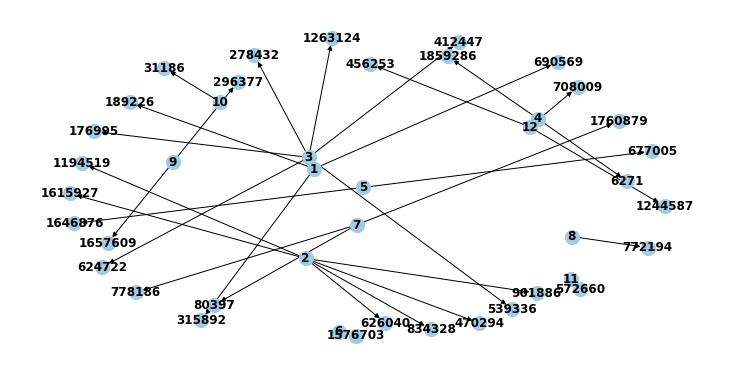

In [17]:
plt.figure(figsize=(10, 5))
pd.read_csv('data/train_woheader.csv',
            nrows=30).to_csv('data/train_woheader_sample.csv', index=False)

subgraph = nx.read_edgelist('data/train_woheader_sample.csv',
                            delimiter=',',
                            create_using=nx.DiGraph(),
                            nodetype=int)

pos = nx.spring_layout(subgraph)

options = {
    'node_size': 200,
}

nx.draw(subgraph,
        pos,
        node_color='#A0CBE2',
        edge_color='black',
        edge_cmap=plt.cm.Blues,
        with_labels=True,
        font_weight='bold',
        **options)

print(nx.info(subgraph))

**Number of followers of each person**

Observe the figure below. 99 percent people have <= 40 followers.

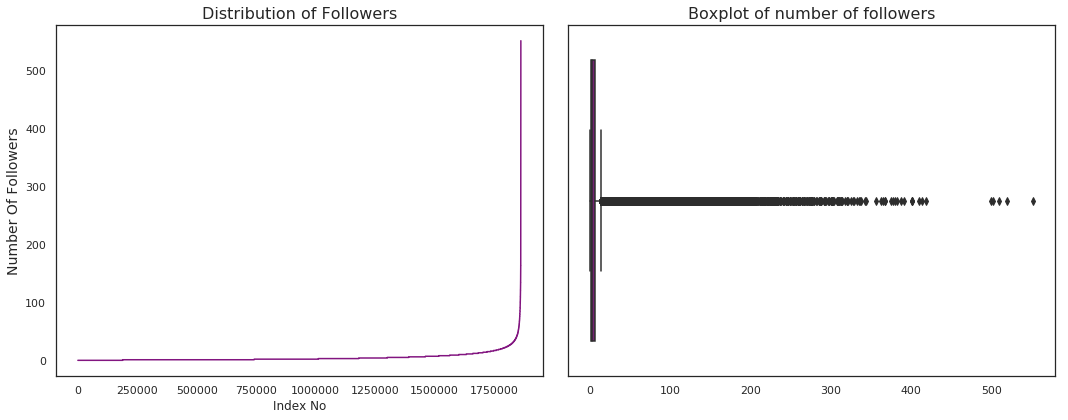

In [114]:
plt.figure(figsize=(15,6))
sbn.set('notebook')
sbn.set_style('white')
sbn.set_palette('BuPu_r')

plt.subplot(1,2,1)
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()

plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('Number Of Followers', fontsize=14)
plt.title('Distribution of Followers', fontsize=16)
plt.xticks(rotation=0)

plt.subplot(1,2,2)
sbn.boxplot(indegree_dist)
plt.title('Boxplot of number of followers', fontsize=16)

plt.tight_layout()
plt.show()

## Percentile distribution of indegree

As you can observe in the graph below, 99 percentile of number of followers is around 40.

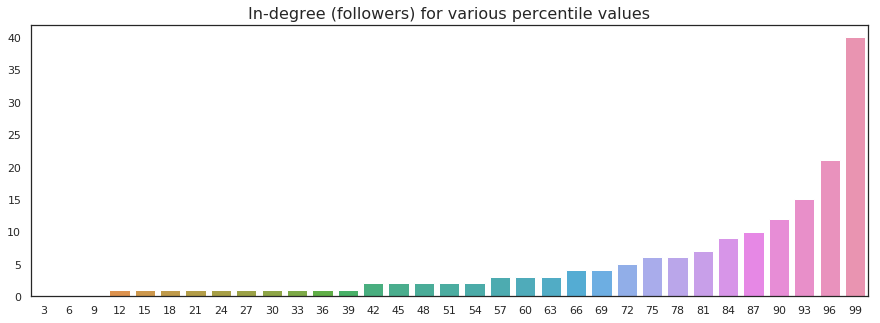

In [135]:
plt.figure(figsize=(15,5))
p=[]
for x in range(3, 100, 3):
    p.append(np.percentile(indegree_dist, x))

ax = sbn.barplot(list(range(3, 100, 3)), p)

plt.title('In-degree (followers) for various percentile values', fontsize=16)
plt.show()

## The problem of missing links (class 0 for the ML models)

There are 9.4 million edges in our data. But is that sufficient? To train a machine learning model which is able to predict whether there's an edge between two nodes, i.e. whether the first node is following the second node, we need representation of the positive class (edge exists), as well as the negative class (edge doesn't exist). Otherwise, how would to model learn to recognize class 0?

But, the graph we've built represents only class 1, obviously. Therefore, we need to synthesize class 0 data points.

To that end, we add the same number of negative cases i.e. where there's no edge between the nodes.

NOTE: Here, I'm using the data provided by AAIC to load missing links.

In [4]:
df_Edge_train = pd.read_csv('./data/after_eda/train_pos_after_eda.csv', header=None)
df_noEdge_train = pd.read_csv('./data/after_eda/train_neg_after_eda.csv', header=None)

In [5]:
df_Edge_train.shape, df_noEdge_train.shape

((7550015, 2), (7550015, 2))

**Create a new column - edge_exists in the data**

In [6]:
df_Edge_train.columns = ['source', 'destination']
df_Edge_train['edge_exists'] = 1
df_noEdge_train.columns = ['source', 'destination']
df_noEdge_train['edge_exists'] = 0

df_train = pd.concat([df_Edge_train, df_noEdge_train], axis=0)

**Shuffle all rows so that positive and negative cases appear randomly**

In [7]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

Sample of the resultant dataset which contains both positive and negative classes

In [8]:
df_train.head(20)

,source,destination,edge_exists
0,1748054,464893,0
1,1151391,843274,0
2,961618,480610,0
3,589034,55429,0
4,1380182,987612,1
5,905992,1746011,0
6,427128,909328,1
7,483872,916638,1
8,883556,1753409,1
9,295599,1772113,1


Similarly, load test data and add the column edge_exists

In [9]:
df_Edge_test = pd.read_csv('./data/after_eda/test_pos_after_eda.csv', header=None)
df_noEdge_test = pd.read_csv('./data/after_eda/test_neg_after_eda.csv', header=None)

In [10]:
df_Edge_test.shape, df_noEdge_test.shape

((1887504, 2), (1887504, 2))

In [11]:
df_Edge_test.columns = ['source', 'destination']
df_Edge_test['edge_exists'] = 1
df_noEdge_test.columns = ['source', 'destination']
df_noEdge_test['edge_exists'] = 0

df_test = pd.concat([df_Edge_test, df_noEdge_test], axis=0)

**Shuffle all rows**

In [12]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [13]:
df_test.head(20)

,source,destination,edge_exists
0,1105846,606770,0
1,1369115,86374,0
2,1381420,1034454,1
3,225532,1618749,1
4,1741219,1501190,0
5,1421676,1544558,1
6,45998,917432,1
7,884424,51258,0
8,936038,1499437,1
9,717126,1413404,0


# Create a graph from the training data

To avoid data leakage, we must use the graph built only on the training data.

In [4]:
g_train = nx.read_edgelist('./data/after_eda/train_pos_after_eda.csv',
                               delimiter=',', create_using=nx.DiGraph(), nodetype=int)
print(nx.info(g_train))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# Feature Engineering  

So far, We've added new edges to the data such that class 0 (no edge) and class 1 (edge) have equal, 50-50 representation. But there's nothing in the data yet from which a ML model could *learn*. In the following sections, we will create some features which will add information to this raw data.

## 1. Jaccard coefficient for followers and followees

The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)

For our data, this means intersection of following/followers divided by union of following/followers. Let's create functions to calculate these values.

In [16]:
type(g_train)

networkx.classes.digraph.DiGraph

In [17]:
# for followees
def jaccard_for_followees(a, b):
    try:
        if len(set(g_train.successors(a))) == 0 | len(set(g_train.successors(b))) == 0:
            return 0
        sim = (len(set(g_train.successors(a)).intersection(set(g_train.successors(b))))) /\
            (len(set(g_train.successors(a)).union(set(g_train.successors(b)))))
    except:
        return 0
    return sim


# for followers
def jaccard_for_followers(a, b):
    try:
        if len(set(g_train.predecessors(a))) == 0 | len(set(g_train.predecessors(b))) == 0:
            return 0
        sim = (len(set(g_train.predecessors(a)).intersection(set(g_train.predecessors(b))))) /\
            (len(set(g_train.predecessors(a)).union(set(g_train.predecessors(b)))))
        return sim
    except:
        return 0

**Jaccard coefficient for followers**

In [18]:
%%notify

df_train['jaccard_followers'] = df_train.progress_apply(lambda row:
                                                        jaccard_for_followers(row['source'],
                                                                              row['destination']), axis=1)

df_test['jaccard_followers'] = df_test.progress_apply(lambda row:
                                                      jaccard_for_followers(row['source'],
                                                                            row['destination']), axis=1)

100%|██████████| 3775008/3775008 [02:40<00:00, 23510.41it/s]


<IPython.core.display.Javascript object>

**Jaccard coefficient for followees**

In [23]:
%%notify

# mapping jaccard followees to train and test data
df_train['jaccard_followees'] = df_train.progress_apply(lambda row:
                                               jaccard_for_followees(row['source'], row['destination']), axis=1)
df_test['jaccard_followees'] = df_test.progress_apply(lambda row:
                                             jaccard_for_followees(row['source'], row['destination']), axis=1)

100%|██████████| 3775008/3775008 [02:46<00:00, 22680.52it/s]


<IPython.core.display.Javascript object>

Save the dataframes back to the disk.

In [38]:
%%notify
df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

<IPython.core.display.Javascript object>

## 2. Cosine similarity for followers and followees

We'll use a different variant of the cosine similarity called "Otsuka-Ochiai coefficient", which is defined as

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/ad3bea56ed57c8e02ec743821f22efdc0ec5e9f4)

In [28]:
# for followees
def cosine_for_followees(a, b):
    try:
        if len(set(g_train.successors(a))) == 0 | len(set(g_train.successors(b))) == 0:
            return 0
        sim = (len(set(g_train.successors(a)).intersection(set(g_train.successors(b))))) /\
            (math.sqrt(len(set(g_train.successors(a)))
                       * len((set(g_train.successors(b))))))
        return sim
    except:
        return 0


def cosine_for_followers(a, b):
    try:

        if len(set(g_train.predecessors(a))) == 0 | len(set(g_train.predecessors(b))) == 0:
            return 0
        sim = (len(set(g_train.predecessors(a)).intersection(set(g_train.predecessors(b))))) /\
            (math.sqrt(len(set(g_train.predecessors(a))))
             * (len(set(g_train.predecessors(b)))))
        return sim
    except:
        return 0

In [29]:
%%notify

df_train['cosine_followers'] = df_train.progress_apply(lambda row:
                                              cosine_for_followers(row['source'], row['destination']), axis=1)
df_test['cosine_followers'] = df_test.progress_apply(lambda row:
                                            cosine_for_followers(row['source'], row['destination']), axis=1)

100%|██████████| 3775008/3775008 [02:27<00:00, 25510.69it/s]


<IPython.core.display.Javascript object>

In [31]:
%%notify

df_train['cosine_followees'] = df_train.progress_apply(lambda row:
                                        cosine_for_followees(row['source'],row['destination']),axis=1)
df_test['cosine_followees'] = df_test.progress_apply(lambda row:
                                        cosine_for_followees(row['source'],row['destination']),axis=1)

100%|██████████| 3775008/3775008 [02:30<00:00, 25063.19it/s]


<IPython.core.display.Javascript object>

In [18]:
%%notify
df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

<IPython.core.display.Javascript object>

## 3. Follows back

This feature checks whether the destination node is following the source node.

In [33]:
def follows_back(a,b):
    
    if g_train.has_edge(b,a):
        return 1
    else:
        return 0

In [35]:
%%notify

df_train['follows_back'] = df_train.progress_apply(
    lambda row: follows_back(row['source'], row['destination']), axis=1)

# mapping followback or not on test
df_test['follows_back'] = df_test.progress_apply(
    lambda row: follows_back(row['source'], row['destination']), axis=1)

100%|██████████| 3775008/3775008 [01:38<00:00, 38316.82it/s]


<IPython.core.display.Javascript object>

## 4. shortest path

This feature stores the shortest path between the source and destination. Shorter the distance, more the chance of two nodes getting connected in the future

In [6]:
#if has direct edge then deleting that edge and calculating shortest path
import copy
g_ = copy.deepcopy(g_train)

def compute_shortest_path_length(a, b):
    p = -1

    try:
        if g_.has_edge(a, b):
            g_.remove_edge(a, b)
            p = nx.shortest_path_length(g_, source=a, target=b)
            g_.add_edge(a, b)
        else:
            p = nx.shortest_path_length(g_, source=a, target=b)
        return p
    except:
        return -1

In [5]:
df_train = pd.read_csv('df_train_partial.csv')
df_test = pd.read_csv('df_test_partial.csv')

In [12]:
%%notify

# mapping shortest path on train
df_train['shortest_path'] = df_train.progress_apply(
    lambda row: compute_shortest_path_length(row['source'], row['destination']), axis=1)

# mapping shortest path on test
df_test['shortest_path'] = df_test.progress_apply(
    lambda row: compute_shortest_path_length(row['source'], row['destination']), axis=1)

100%|██████████| 3775008/3775008 [29:55<00:00, 2102.25it/s]


<IPython.core.display.Javascript object>

Save the dataframes to disk to avoid computing the new features again

In [14]:
%%notify
df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

<IPython.core.display.Javascript object>

In [20]:
# %%notify
# df_train.to_csv('df_train_partial.csv', index=False)
# df_test.to_csv('df_test_partial.csv', index=False)

<IPython.core.display.Javascript object>

## 5. PageRank

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages. NetworkX provides a handy function to calculate pagerank of every node in the graph.

In [15]:
%%notify
pr = nx.pagerank(g_train, alpha=0.85)

<IPython.core.display.Javascript object>

In [16]:
pickle.dump(pr,open('page_rank_train.pkl','wb'))

In [38]:
pr = pickle.load(open('page_rank_train.pkl', 'rb'))

In [39]:
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699365892e-07


In [42]:
%%notify

df_train['pr_source'] = df_train['source'].map(lambda x: pr.get(x, mean_pr))
df_train['pr_destination'] = df_train['destination'].map(lambda x: pr.get(x, mean_pr))
df_test['pr_source'] = df_test['source'].map(lambda x: pr.get(x, mean_pr))
df_test['pr_destination'] = df_test['destination'].map(lambda x: pr.get(x, mean_pr))

<IPython.core.display.Javascript object>

## 6. Weakly conncected component

In this feature, we check whether the source and destination nodes belong to the same weakly connected component.

A weakly connected component is a maximal subgraph of a directed graph such that for every pair of vertices u, v in the subgraph, there is an path from u to v. If the source and destination nodes belong to the same WCC, higher the chance of they belonging to the same community of people and thus being connected in future.

In [7]:
# getting weekly connected edges from graph
wcc = list(nx.weakly_connected_components(g_))


def belongs_to_same_wcc(a, b):
    index = []
    if g_.has_edge(b, a):
        return 1
    if g_.has_edge(a, b):
        for i in wcc:
            if a in i:
                index = i
                break
        if (b in index):
            g_.remove_edge(a, b)
            if compute_shortest_path_length(a, b) == -1:
                g_.add_edge(a, b)
                return 0
            else:
                g_.add_edge(a, b)
                return 1
        else:
            return 0
    else:
        for i in wcc:
            if a in i:
                index = i
                break
        if (b in index):
            return 1
        else:
            return 0

In [22]:
len(wcc)

48602

In [ ]:
%%notify

# mapping same component of wcc or not on train
df_train['same_component'] = df_train.progress_apply(
    lambda row: belongs_to_same_wcc(row['source'], row['destination']), axis=1)

# mapping same component of wcc or not on train
df_test['same_component'] = df_test.progress_apply(lambda row: belongs_to_same_wcc(
    row['source'], row['destination']), axis=1)

In [11]:
%%notify
df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

<IPython.core.display.Javascript object>

## 7 Adamic/Adar Index

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [11]:
# adar index
def calc_adar_in(a, b):
    sum = 0
    try:
        n = list(
            set(g_train.successors(a)).intersection(set(
                g_train.successors(b))))
        if len(n) != 0:
            for i in n:
                sum = sum + (1 / np.log10(len(list(g_train.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [12]:
%%notify

# mapping adar index on train
df_train['adar_index'] = df_train.progress_apply(
    lambda row: calc_adar_in(row['source'], row['destination']), axis=1)

# mapping adar index on test
df_test['adar_index'] = df_test.progress_apply(
    lambda row: calc_adar_in(row['source'], row['destination']), axis=1)

100%|██████████| 3775008/3775008 [04:04<00:00, 15410.57it/s]


<IPython.core.display.Javascript object>

## 8. Katz centrality

Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigenvector centrality. The Katz centrality for node i is

![](https://networkx.github.io/documentation/networkx-1.10/_images/math/7d9eab1f5f973e768e2bf1204108448cfb080094.png)

where A is the adjacency matrix of the graph G with eigenvalues \lambda.

The parameter \beta controls the initial centrality and


![](https://networkx.github.io/documentation/networkx-1.10/_images/math/ebb85cf5e38537ff0b536e7b7876387dcecdc0e1.png)

Katz centrality computes the relative influence of a node within a network by measuring the number of the immediate neighbors (first degree nodes) and also all other nodes in the network that connect to the node under consideration through these immediate neighbors.

In [6]:
%%notify
katz = nx.katz.katz_centrality(g_train, alpha=0.005, beta=1)

<IPython.core.display.Javascript object>

In [7]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935501884


In [8]:
%%notify

#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_train['katz_s'] = df_train.source.progress_apply(lambda x: katz.get(x, mean_katz))
df_train['katz_d'] = df_train.destination.progress_apply(lambda x: katz.get(x, mean_katz))

df_test['katz_s'] = df_test.source.progress_apply(lambda x: katz.get(x, mean_katz))
df_test['katz_d'] = df_test.destination.progress_apply(lambda x: katz.get(x, mean_katz))

100%|██████████| 3775008/3775008 [00:08<00:00, 436081.60it/s]


<IPython.core.display.Javascript object>

**correlation between the source and destination Katz centrality values**

In [9]:
df_train[['katz_s', 'katz_d']].corr()

,katz_s,katz_d
katz_s,1.000000,0.638912
katz_d,0.638912,1.000000


In [10]:
df_test[['katz_s', 'katz_d']].corr()

,katz_s,katz_d
katz_s,1.000000,0.635525
katz_d,0.635525,1.000000


## 9. Hits score

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

In [12]:
%%notify

hits = nx.hits(g_train, max_iter=100, tol=1e-08, nstart=None, normalized=True)

<IPython.core.display.Javascript object>

In [13]:
pickle.dump(hits, open('hits.pkl', 'wb'))

In [6]:
#hits = pickle.load(open('hits.pkl', 'rb'))

In [14]:
%%notify

# Hits algorithm score for source and destination in Train and test
# if anything is not there in train graph then adding 0
df_train['hubs_s'] = df_train.source.progress_apply(lambda x: hits[0].get(x, 0))
df_train['hubs_d'] = df_train.destination.progress_apply(lambda x: hits[0].get(x, 0))

df_test['hubs_s'] = df_test.source.progress_apply(lambda x: hits[0].get(x, 0))
df_test['hubs_d'] = df_test.destination.progress_apply(lambda x: hits[0].get(x, 0))
# ================================================================================

# Hits algorithm score for source and destination in Train and Test
# if anything is not there in train graph then adding 0
df_train['authorities_s'] = df_train.source.progress_apply(lambda x: hits[1].get(x, 0))
df_train['authorities_d'] = df_train.destination.progress_apply(
    lambda x: hits[1].get(x, 0))

df_test['authorities_s'] = df_test.source.progress_apply(lambda x: hits[1].get(x, 0))
df_test['authorities_d'] = df_test.destination.progress_apply(
    lambda x: hits[1].get(x, 0))
# ================================================================================

100%|██████████| 3775008/3775008 [00:09<00:00, 416381.17it/s]


<IPython.core.display.Javascript object>

In [15]:
%%notify
df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

<IPython.core.display.Javascript object>

## 10. Weight features

In order to determine the similarity of nodes, an edge weight value can be calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 


`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

In [16]:
%%notify

#weight for source and destination of each link
Weight_in = {}
Weight_out = {}

for i in  tqdm(g_train.nodes()):
    s1=set(g_train.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(g_train.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:19<00:00, 92574.29it/s]


<IPython.core.display.Javascript object>

In [17]:
%%notify
df_train['weight_in'] = df_train.destination.progress_apply(lambda x: Weight_in.get(x,mean_weight_in))
df_train['weight_out'] = df_train.source.progress_apply(lambda x: Weight_out.get(x,mean_weight_out))

#mapping to pandas test
df_test['weight_in'] = df_test.destination.progress_apply(lambda x: Weight_in.get(x,mean_weight_in))
df_test['weight_out'] = df_test.source.progress_apply(lambda x: Weight_out.get(x,mean_weight_out))

100%|██████████| 3775008/3775008 [00:10<00:00, 355137.68it/s]


<IPython.core.display.Javascript object>

In [18]:
%%notify
df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

<IPython.core.display.Javascript object>

In [5]:
df_train = pd.read_csv('df_train_partial.csv')
df_test = pd.read_csv('df_test_partial.csv')

## 11. SVD features

In [6]:
# this is a mappig for svd features
sadj_col = sorted(g_train.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [7]:
%%notify
Adj = nx.adjacency_matrix(g_train, nodelist=sorted(g_train.nodes())).asfptype()

<IPython.core.display.Javascript object>

In [8]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [9]:
from scipy.sparse.linalg import svds, eigs

In [10]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


Save the decomposed matrices on to the disk

In [7]:
# pickle.dump(U, open('U.pkl', 'wb'))
# pickle.dump(s, open('s.pkl', 'wb'))
# pickle.dump(V, open('V.pkl', 'wb'))

U = pickle.load(open('U.pkl', 'rb'))
s = pickle.load(open('s.pkl', 'rb'))
V = pickle.load(open('V.pkl', 'rb'))

In [11]:
%%notify

df_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_train.source.progress_apply(lambda x: svd(x, U)).progress_apply(pd.Series)

df_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_test.source.progress_apply(lambda x: svd(x, U)).progress_apply(pd.Series)

100%|██████████| 3775008/3775008 [11:49<00:00, 5320.32it/s] 


<IPython.core.display.Javascript object>

In [12]:
df_train.shape, df_test.shape

((15100030, 27), (3775008, 27))

In [13]:
%%notify
df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

<IPython.core.display.Javascript object>

In [14]:
%%notify
df_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_train.destination.progress_apply(lambda x: svd(x, U)).progress_apply(pd.Series)

df_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_test.destination.progress_apply(lambda x: svd(x, U)).progress_apply(pd.Series)

df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

100%|██████████| 3775008/3775008 [11:07<00:00, 5652.87it/s] 


<IPython.core.display.Javascript object>

In [15]:
%%notify

df_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_train.source.progress_apply(lambda x: svd(x, V.T)).progress_apply(pd.Series)

df_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_test.source.progress_apply(lambda x: svd(x, V.T)).progress_apply(pd.Series)

df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

100%|██████████| 3775008/3775008 [11:38<00:00, 5402.37it/s] 


<IPython.core.display.Javascript object>

In [16]:
df_test.shape, df_train.shape

((3775008, 39), (15100030, 39))

In [17]:
%%notify
df_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_train.destination.progress_apply(lambda x: svd(x, V.T)).progress_apply(pd.Series)

df_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_test.destination.progress_apply(lambda x: svd(x, V.T)).progress_apply(pd.Series)

df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

100%|██████████| 3775008/3775008 [11:14<00:00, 5598.11it/s] 


<IPython.core.display.Javascript object>

done upto here

In [20]:
df_train.shape, df_test.shape

((15100030, 45), (3775008, 45))

## 12. SVD dot feature


This is a dot product between the source SVD features and destination SVD features

In [8]:
df_train.columns

Index(['source', 'destination', 'edge_exists', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'follows_back', 'shortest_path', 'pr_source', 'pr_destination',
       'same_component', 'adar_index', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'weight_in', 'weight_out',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [ ]:
%%notify

df_train['svd_DOT'] = df_train.progress_apply(lambda x: np.dot(x[['svd_u_s_1', 'svd_u_s_2', 
                                                         'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
                                                         'svd_u_s_6', 'svd_v_s_1', 'svd_v_s_2', 
                                                         'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
                                                         'svd_v_s_6']],
                                                      x[['svd_u_d_1', 'svd_u_d_2',
                                                         'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
                                                         'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2',
                                                         'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
                                                         'svd_v_d_6']]), axis=1)

df_train.to_csv('df_train_partial.csv', index=False)

SVD dot feature for test data

In [ ]:
%%notify

df_test['svd_DOT'] = df_test.progress_apply(lambda x: np.dot(x[['svd_u_s_1', 'svd_u_s_2', 
                                                         'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
                                                         'svd_u_s_6', 'svd_v_s_1', 'svd_v_s_2', 
                                                         'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
                                                         'svd_v_s_6']],
                                                      x[['svd_u_d_1', 'svd_u_d_2',
                                                         'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
                                                         'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2',
                                                         'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
                                                         'svd_v_d_6']]), axis=1)

df_test.to_csv('df_test_partial.csv', index=False)

## 13. Preferential Attachment

Preferential Attachment - One well-known concept in social networks is that users with many friends tend to create more connections in the future. We estimate PA between our two vertices by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. 

In [13]:
def preferential_attachment_followers(source, destination):
    try:
        return len(list(g_train.predecessors(source))) * len(list(g_train.predecessors(destination)))
    except:
        return -1
    
    
def preferential_attachment_followees(source, destination):
    try:
        return len(list(g_train.successors(source))) * len(list(g_train.successors(destination)))
    except:
        return -1

In [15]:
%%notify

df_train['PA_followers'] = df_train.apply(
    lambda row: preferential_attachment_followers(row['source'], row['destination']), axis=1)


df_train['PA_followees'] = df_train.apply(
    lambda row: preferential_attachment_followees(row['source'], row['destination']), axis=1)



df_test['PA_followers'] = df_test.apply(
    lambda row: preferential_attachment_followers(row['source'], row['destination']), axis=1)



df_test['PA_followees'] = df_test.apply(
    lambda row: preferential_attachment_followees(row['source'], row['destination']), axis=1)



<IPython.core.display.Javascript object>

**The feature engineering is now done. Let's look at what we've got in the final dataset**

In [18]:
df_train.columns

Index(['source', 'destination', 'edge_exists', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'follows_back', 'shortest_path', 'pr_source', 'pr_destination',
       'same_component', 'adar_index', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'weight_in', 'weight_out',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_DOT',
       'PA_followers', 'PA_followees'],
      dtype='object')

In [21]:
df_test.columns

Index(['source', 'destination', 'edge_exists', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'follows_back', 'shortest_path', 'pr_source', 'pr_destination',
       'same_component', 'adar_index', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'weight_in', 'weight_out',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_DOT',
       'PA_followers', 'PA_followees'],
      dtype='object')

In [45]:
df_train.to_csv('df_train_partial.csv', index=False)
df_test.to_csv('df_test_partial.csv', index=False)

# Train and Test data for Machine Learning


We have preprocessed the data, and now it is time to do some machine learning. But there are a couple of last steps remaining. First, we need to drop the columns source, destination from the data because their job is done and they add no value to the learning process.

Second, we'll standardize the data so that it makes the learning easier during optimization methods like gradient descent.

In [46]:
X_train = df_train.drop(['source', 'destination', 'edge_exists',
                         'cosine_followers', 'cosine_followees'], axis=1).values

y_train = df_train['edge_exists'].values

X_test = df_test.drop(['source', 'destination', 'edge_exists',
                         'cosine_followers', 'cosine_followees'], axis=1).values

y_test = df_test['edge_exists'].values

In [4]:
%%notify
# pickle.dump(X_train, open('X_train.pkl', 'wb'), protocol=4)
# pickle.dump(X_test, open('X_test.pkl', 'wb'), protocol=4)
# pickle.dump(y_train, open('y_train.pkl', 'wb'), protocol=4)
# pickle.dump(y_test, open('y_test.pkl', 'wb'), protocol=4)


X_train = pickle.load(open('X_train.pkl', 'rb'))
X_test = pickle.load(open('X_test.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))

<IPython.core.display.Javascript object>

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15100030, 43), (15100030,), (3775008, 43), (3775008,))

**Standardize data**

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Functions to display model performance

In [6]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))

    labels = [1,2]
    # representing A in heatmap format
    cmap=sbn.light_palette("green")
    plt.subplot(1, 3, 1)
    sbn.heatmap(C, annot=True, cmap=cmap, fmt=".0f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sbn.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sbn.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
def plot_model_performance(model,
                           predict_output,
                           fpr,
                           tpr,
                           roc_auc,
                           param_column,
                           titles=None,
                           figures=3):

    print('*' * 50, 'SUMMARY', '*' * 50)

    plt.figure(figsize=(15, 5))
    sbn.set()

    columns = [
        'mean_test_accuracy', 'mean_test_f1', 'mean_test_precision',
        'mean_test_recall'
    ] + [param_column]

    f = 0
    while f < figures - 1:

        plt.subplot(1, figures, f + 1)

        ax = pd.DataFrame(
            model.cv_results_)[columns].loc[f][:4].plot.bar(rot=30)

        for p in ax.patches:
            ax.annotate('{:.3f}'.format((p.get_height())),
                        (p.get_x(), p.get_height() + 0.01),
                        fontsize=13)

        plt.title(titles[f], fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        f += 1

    plt.subplot(1, figures, f + 1)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylim([0, 1])
    plt.legend(loc='best', fontsize=18)
    plt.title(titles[f], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()
    print('*' * 46, 'Confusion Matrix', '*' * 46)
    plot_confusion_matrix(y_test, predict_output)
    plt.show()
    print('*' * 110)

# Model 1: Logistic Regression

In [54]:
%%notify

logreg = LogisticRegression(verbose=3)

param_grid = {'C': [0.1, 1.0]}

model_grdsrch_logreg = GridSearchCV(logreg,
                             param_grid,
                             scoring=['accuracy', 'precision', 'recall', 'f1'],
                             n_jobs=4,
                             refit='f1',
                             cv=3,
                             verbose=3,
                             return_train_score=True)

model_grdsrch_logreg.fit(X_train, y_train)

#pickle.dump(model_grdsrch_logreg, open('model_grdsrch_logreg.pkl', 'wb'))

joblib.dump(model_grdsrch_logreg, 'model_grdsrch_logreg_JL.sav')

pp_output_LR = model_grdsrch_logreg.predict_proba(X_test)
predict_output_LR = model_grdsrch_logreg.predict(X_test)

pickle.dump(pp_output_LR, open('pp_output_LR.pkl', 'wb'))
pickle.dump(predict_output_LR, open('predict_output_LR.pkl', 'wb'))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   6 | elapsed: 20.6min remaining: 41.3min
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed: 59.8min finished
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

<IPython.core.display.Javascript object>

In [63]:
pickle.dump(model_grdsrch_logreg.best_estimator_.coef_, open('logreg_coef.pkl', 'wb'))

In [55]:
#pp_output_LR = pickle.load(open('pp_output_LR.pkl', 'rb'))
#predict_output_LR = pickle.load(open('predict_output_LR.pkl', 'rb'))

accuracy = accuracy_score(y_test, predict_output_LR)
precision = precision_score(y_test, predict_output_LR)
recall = recall_score(y_test, predict_output_LR)
f1 = f1_score(y_test, predict_output_LR)
fpr, tpr, thresholds = roc_curve(y_test, pp_output_LR.max(axis=1))
roc_auc = auc(fpr, tpr)

**Five metrics: Logistic Regression**

In [56]:
print('Accuracy Test data', str(accuracy).rjust(44, ' '))
print('Precision Test data', str(precision).rjust(44, ' '))
print('Recall Test data', str(recall).rjust(47, ' '))
print('f1 score Test data', str(f1).rjust(45, ' '))
print('AUC Test data', str(roc_auc).rjust(50, ' '))

Accuracy Test data                           0.9120295904008681
Precision Test data                           0.9498422357122819
Recall Test data                              0.8700008052963066
f1 score Test data                            0.9081700908844804
AUC Test data                                 0.8426921531447231


In [4]:
table = PrettyTable()
table.field_names = ['#', 'Model', '#Train Data', '#Test Data','Accuracy','Precision', 'Recall', 'f1 score', 'AUC']
table.add_row(['1','Logistic Regression', '15,100,030', '3,775,008','0.91', '0.94', '0.87', '0.90', '0.84'])

**Load the model from the disk**

In [26]:
#model_LR = joblib.load('model_grdsrch_logreg_JL.sav')

**model performance at a glance**

************************************************** SUMMARY **************************************************


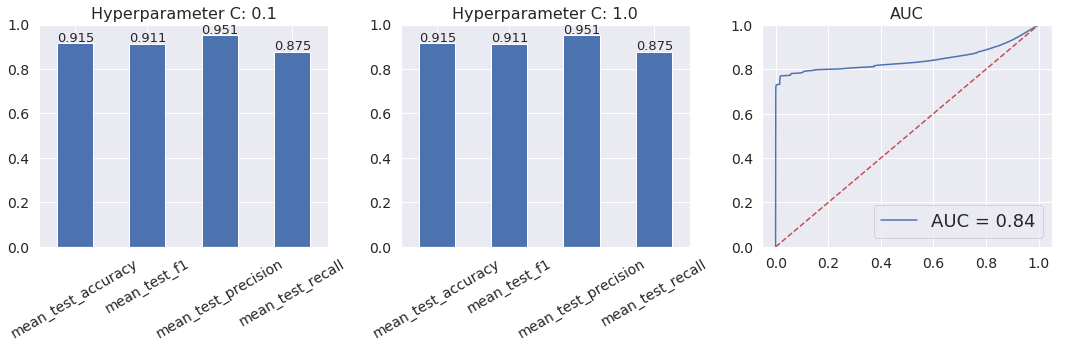

********************************************** Confusion Matrix **********************************************


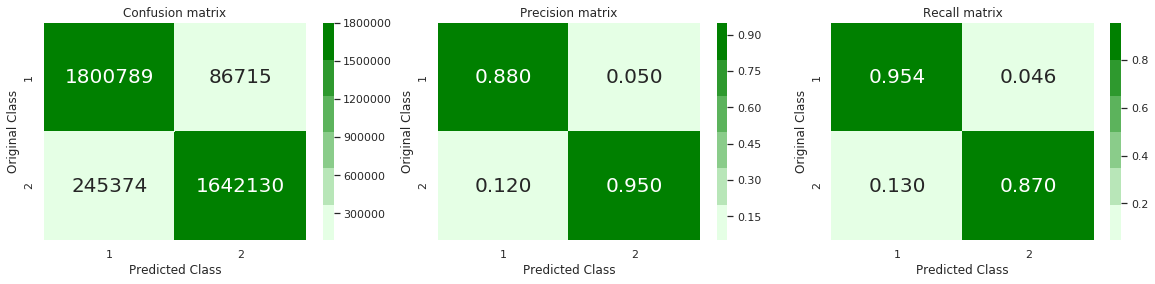

**************************************************************************************************************


In [59]:
plot_model_performance(model_grdsrch_logreg,
                       predict_output_LR,
                       fpr,
                       tpr,
                       roc_auc,
                       'param_C',
                       titles=['Hyperparameter C: 0.1', 'Hyperparameter C: 1.0', 'AUC'],
                       figures=3)

# Feature importance: Logistic Regression

For various ML models we'll train, let's try to obtain the feature importance of the features present in the data.
For Logistic Regression, the following features were crucial for classification

    1. Jaccard Followers
    2. Jaccard Followees
    3. Follows Back
    4. Adar Index
    5. SVD_dot
    6. PA_followers

In [31]:
df_ = pd.read_csv('df_train_partial_3.csv', nrows=2).drop(['source', 'destination', 'edge_exists',
                         'cosine_followers', 'cosine_followees'], axis=1)

feature_names = df_.columns.tolist()

model_LR = joblib.load('model_grdsrch_logreg_JL.sav')
lr_feature_imp=model_LR.best_estimator_.coef_.tolist()[0]

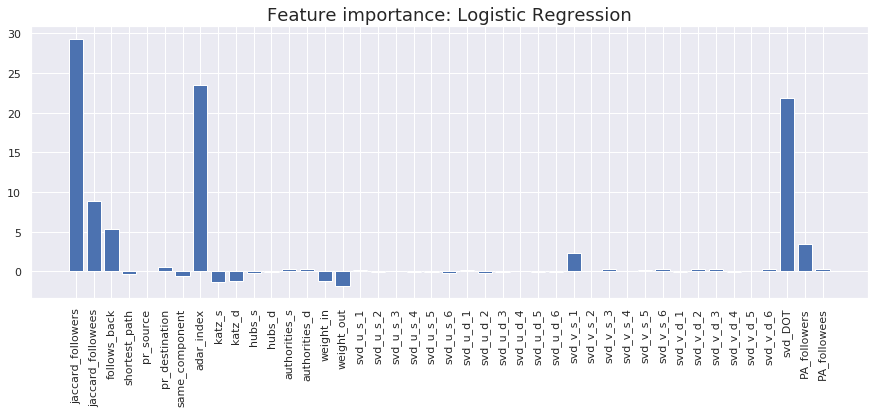

In [52]:
plt.figure(figsize=(15,5))
plt.bar(feature_names, lr_feature_imp)
plt.xticks(rotation=90)
plt.title('Feature importance: Logistic Regression', fontsize=18)
plt.show()

# Model 2: Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
%%notify

rfc = RandomForestClassifier(max_depth=6)

param_grid = {'n_estimators': [10, 20, 30]}

model_grdsrch_rf = GridSearchCV(rfc,
                             param_grid,
                             scoring=['accuracy', 'precision', 'recall', 'f1'],
                             n_jobs=4,
                             refit='f1',
                             cv=3,
                             verbose=2,
                             return_train_score=True,
                             )

model_grdsrch_rf.fit(X_train, y_train)

joblib.dump(model_grdsrch_rf, 'model_grdsrch_rf_JL.sav')

pp_output_RF = model_grdsrch_rf.predict_proba(X_test)
predict_output_RF = model_grdsrch_rf.predict(X_test)

pickle.dump(pp_output_RF, open('pp_output_RF.pkl', 'wb'))
pickle.dump(predict_output_RF, open('predict_output_RF.pkl', 'wb'))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed: 21.6min remaining:  6.2min
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 31.1min finished


<IPython.core.display.Javascript object>

In [69]:
#pp_output_RF = pickle.load(open('pp_output_RF.pkl', 'rb'))
#predict_output_RF = pickle.load(open('predict_output_RF.pkl', 'rb'))

accuracy = accuracy_score(y_test, predict_output_RF)
precision = precision_score(y_test, predict_output_RF)
recall = recall_score(y_test, predict_output_RF)
f1 = f1_score(y_test, predict_output_RF)
fpr, tpr, thresholds = roc_curve(y_test, pp_output_RF.max(axis=1))
roc_auc = auc(fpr, tpr)

In [72]:
pickle.dump(model_grdsrch_rf.best_estimator_.feature_importances_, open('rf_feature_imp.pkl', 'wb'))

**Five metrics: Random Forests**

In [73]:
print('Accuracy Test data', str(accuracy).rjust(44, ' '))
print('Precision Test data', str(precision).rjust(43, ' '))
print('Recall Test data', str(recall).rjust(45, ' '))
print('f1 score Test data', str(f1).rjust(44, ' '))
print('AUC Test data', str(roc_auc).rjust(49, ' '))

Accuracy Test data                           0.8989053798031686
Precision Test data                          0.9732511620159838
Recall Test data                            0.8203574667921234
f1 score Test data                           0.8902877082549349
AUC Test data                                0.6308350286821729


In [6]:
table.add_row(['2','Random Forests', '15,100,030', '3,775,008','0.89', '0.97', '0.82', '0.89', '0.63'])

In [34]:
#model_RF = joblib.load('model_grdsrch_rf_JL.sav')

**Model performance at a glance**

************************************************** SUMMARY **************************************************


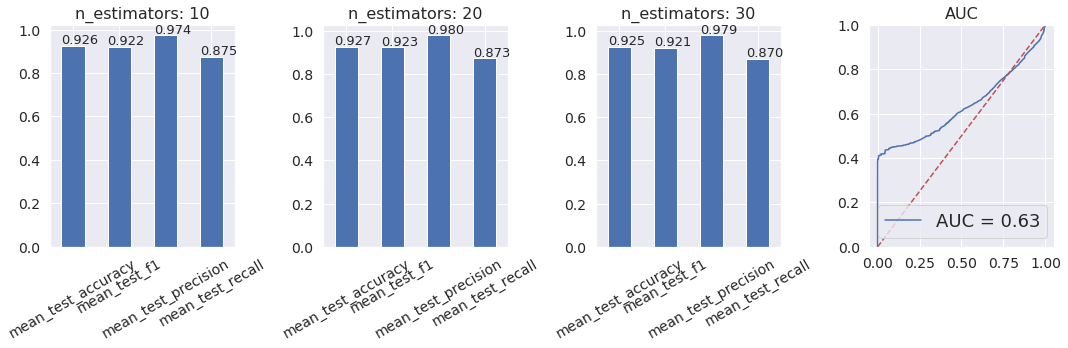

********************************************** Confusion Matrix **********************************************


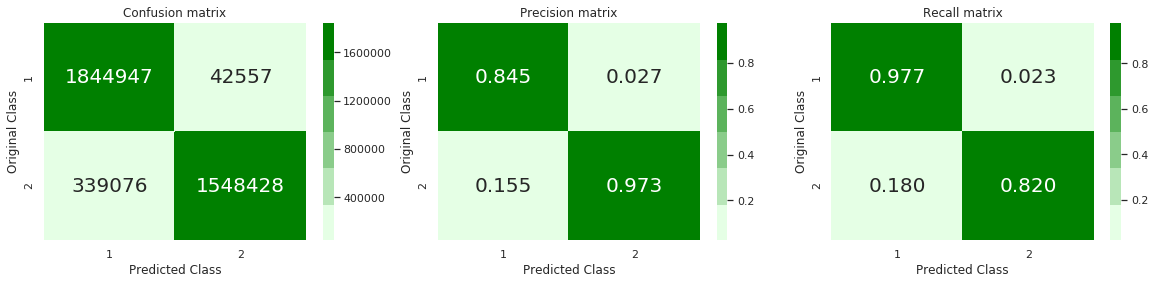

**************************************************************************************************************


In [76]:
plot_model_performance(model_grdsrch_rf,
                       predict_output_RF,
                       fpr,
                       tpr,
                       roc_auc,
                       'param_n_estimators',
                       titles=['n_estimators: 10', 'n_estimators: 20', 'n_estimators: 30', 'AUC'],
                       figures=4)

# Feature importance: Random Forests

Unlike in case of LR, for Random Forests the svd_dot feature didn't matter much. The most important feature was **follows_back**.

In [38]:
model_rf = joblib.load('model_grdsrch_rf_JL.sav')
rf_feature_imp=model_rf.best_estimator_.feature_importances_.tolist()

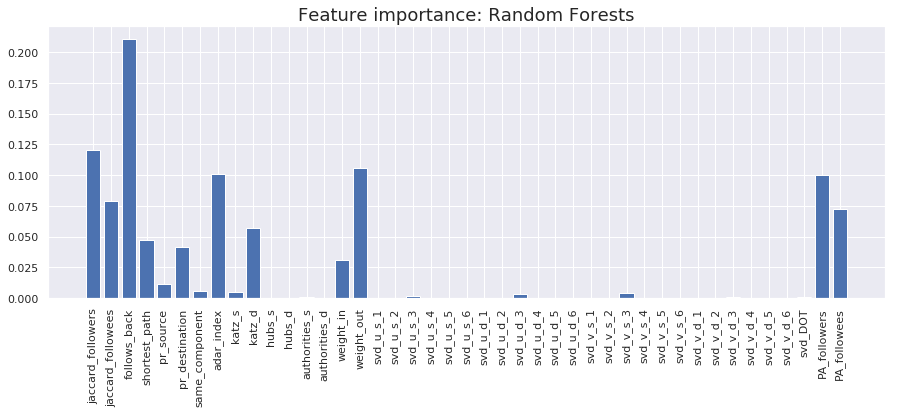

In [40]:
plt.figure(figsize=(15,5))
plt.bar(feature_names, rf_feature_imp)
plt.xticks(rotation=90)
plt.title('Feature importance: Random Forests', fontsize=18)
plt.show()

# Model 3: Gradient Boosting Classifier using XGBoost

This model took ~11 hours to train.

In [7]:
from xgboost import XGBClassifier

In [8]:
%%notify

xgb = XGBClassifier(verbosity=1)

parameters_dict = {'max_depth': [3, 4]}

clf_gridsrch_xgb = GridSearchCV(xgb,
                            param_grid=parameters_dict,
                            n_jobs=4,
                            verbose=1,
                            cv=3,
                            scoring=['accuracy', 'precision', 'recall', 'f1'],
                            refit='f1')

clf_gridsrch_xgb.fit(X_train, y_train)

joblib.dump(clf_gridsrch_xgb, 'clf_gridsrch_xgb_JL.sav')

pp_output_xgb = clf_gridsrch_xgb.best_estimator_.predict_proba(X_test)
predict_output_xgb = clf_gridsrch_xgb.predict(X_test)

pickle.dump(pp_output_xgb, open('pp_output_xgb.pkl', 'wb'))
pickle.dump(predict_output_xgb, open('predict_output_xgb.pkl', 'wb'))

#pickle.dump(clf_gridsrch_xgb, open('model_grdsrch_xgb.pkl', 'wb'))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed: 322.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed: 322.2min finished


[16:23:11] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


<IPython.core.display.Javascript object>

In [25]:
#pp_output_xgb = pickle.load(open('pp_output_xgb.pkl', 'rb'))
#predict_output_xgb = pickle.load(open('predict_output_xgb.pkl', 'rb'))

accuracy = accuracy_score(y_test, predict_output_xgb)
precision = precision_score(y_test, predict_output_xgb)
recall = recall_score(y_test, predict_output_xgb)
f1 = f1_score(y_test, predict_output_xgb)
fpr, tpr, thresholds = roc_curve(y_test, pp_output_xgb.max(axis=1))
roc_auc = auc(fpr, tpr)

**Five metrics: XGBoost**

In [26]:
print('Accuracy Test data', str(accuracy).rjust(44, ' '))
print('Precision Test data', str(precision).rjust(43, ' '))
print('Recall Test data', str(recall).rjust(46, ' '))
print('f1 score Test data', str(f1).rjust(44, ' '))
print('AUC Test data', str(roc_auc).rjust(49, ' '))

Accuracy Test data                           0.9224197670574473
Precision Test data                          0.9737036288885192
Recall Test data                             0.8682890208444591
f1 score Test data                            0.917979961150083
AUC Test data                                0.7518279280828053


In [8]:
table.add_row(['3','Gradient Boosting', '15,100,030', '3,775,008','0.92', '0.97', '0.87', '0.92', '0.75'])

In [38]:
# model_xgb = joblib.load('clf_gridsrch_xgb_JL.sav')

**Model performance at a glance**

************************************************** SUMMARY **************************************************


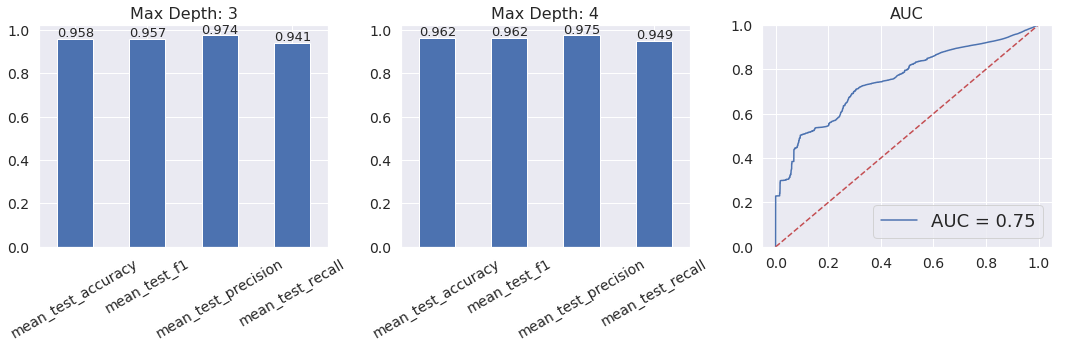

********************************************** Confusion Matrix **********************************************


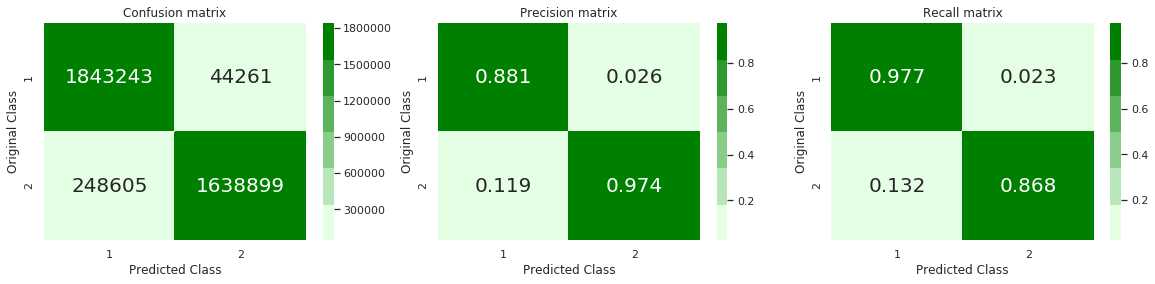

**************************************************************************************************************


In [27]:
plot_model_performance(clf_gridsrch_xgb,
                       predict_output_xgb,
                       fpr,
                       tpr,
                       roc_auc,
                       'param_max_depth',
                       titles=['Max Depth: 3', 'Max Depth: 4', 'AUC'],
                       figures=3)

# Feature importance: XGBoost

In [37]:
xgb_feature_imp = clf_gridsrch_xgb.best_estimator_.feature_importances_.tolist()
pickle.dump(xgb_feature_imp, open('xgb_feature_imp.pkl', 'wb'))

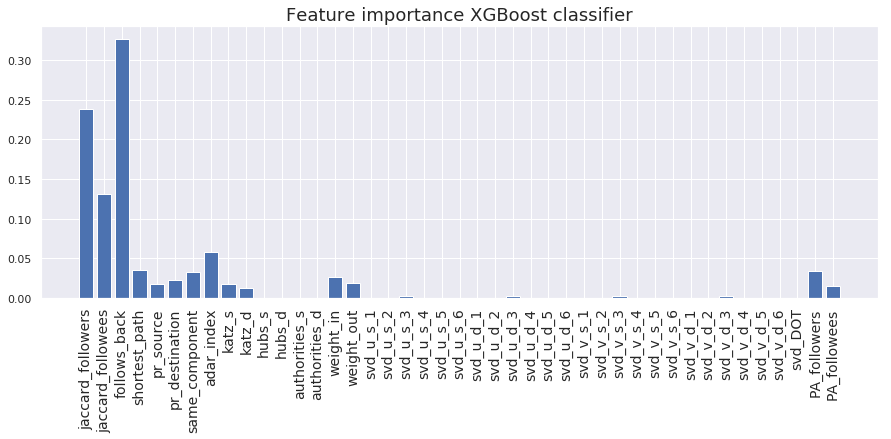

In [36]:
plt.figure(figsize=(15,5))
plt.bar(feature_names, xgb_feature_imp)
plt.xticks(rotation=90, fontsize=14)
plt.title('Feature importance XGBoost classifier', fontsize=18)
plt.show()

# Model 4: LinearSVC

In [ ]:
%%notify
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC(penalty='l2', verbose=2, random_state=19, max_iter=700)

clf = CalibratedClassifierCV(svc) 

parameters_dict = {'base_estimator__C': [1, 10]}

clf_gridsrch_svc = GridSearchCV(clf,
                            param_grid=parameters_dict,
                            n_jobs=5,
                            verbose=2,
                            cv=3,
                            scoring=['accuracy', 'precision', 'recall', 'f1'],
                            refit='f1')

clf_gridsrch_svc.fit(X_train, y_train)


joblib.dump(clf_gridsrch_svc, 'model_grdsrch_SVC_JL.sav')

pp_output_SVC = clf_gridsrch_svc.best_estimator_.predict_proba(X_test)
predict_output_SVC = clf_gridsrch_svc.predict(X_test)

pickle.dump(pp_output_SVC, open('pp_output_SVC.pkl', 'wb'))
pickle.dump(predict_output_SVC, open('predict_output_SVC.pkl', 'wb'))


# pickle.dump(clf_gridsrch_svc, open('model_grdsrch_svc.pkl', 'wb'))

In [12]:
#pp_output_SVC = pickle.load(open('pp_output_SVC.pkl', 'rb'))
#predict_output_SVC = pickle.load(open('predict_output_SVC.pkl', 'rb'))

accuracy = accuracy_score(y_test, predict_output_SVC)
precision = precision_score(y_test, predict_output_SVC)
recall = recall_score(y_test, predict_output_SVC)
f1 = f1_score(y_test, predict_output_SVC)
fpr, tpr, thresholds = roc_curve(y_test, pp_output_SVC.max(axis=1))
roc_auc = auc(fpr, tpr)

**Five metrics: Linear SVC**

In [21]:
print('Accuracy Test data', str(accuracy).rjust(44, ' '))
print('Precision Test data', str(precision).rjust(43, ' '))
print('Recall Test data', str(recall).rjust(46, ' '))
print('f1 score Test data', str(f1).rjust(44, ' '))
print('AUC Test data', str(roc_auc).rjust(50, ' '))

Accuracy Test data                           0.6920382685281726
Precision Test data                          0.9999972411890475
Recall Test data                             0.3840775966567488
f1 score Test data                           0.5549938869737037
AUC Test data                                0.23620157230843672


In [9]:
table.add_row(['4','Linear SVC', '15,100,030', '3,775,008','0.69', '0.99', '0.38', '0.55', '0.23'])

In [41]:
# model_SVC = joblib.load('model_grdsrch_SVC_JL.sav')

**Model performance at a glance**

************************************************** SUMMARY **************************************************


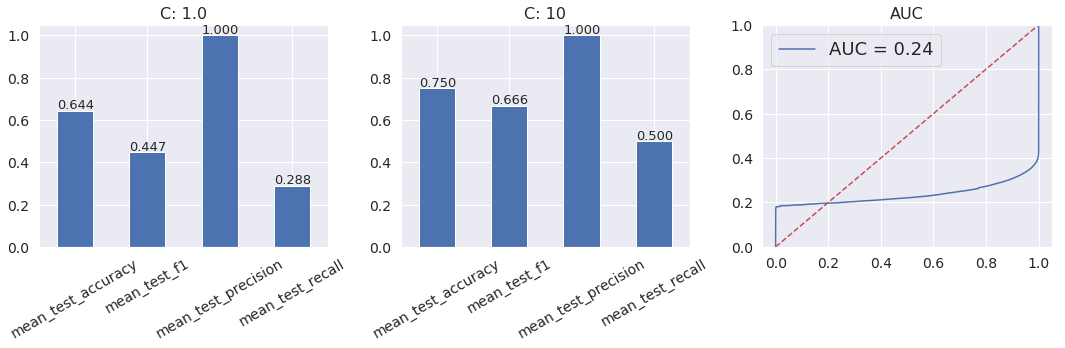

********************************************** Confusion Matrix **********************************************


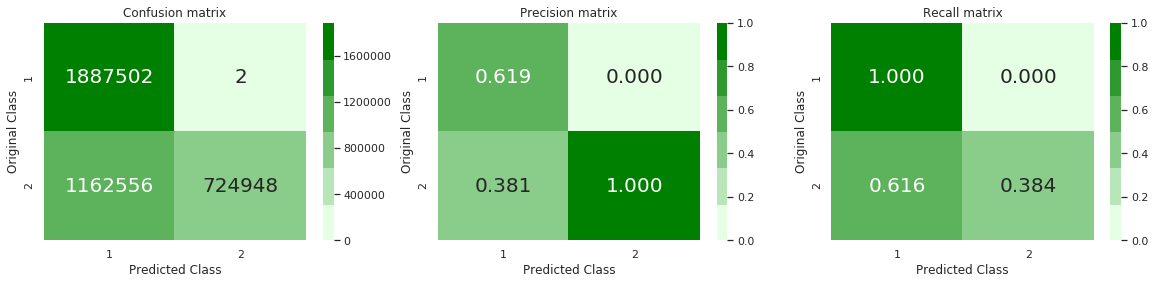

**************************************************************************************************************


In [22]:
plot_model_performance(clf_gridsrch_svc,
                       predict_output_SVC,
                       fpr,
                       tpr,
                       roc_auc,
                       'param_base_estimator__C',
                       titles=['C: 1.0', 'C: 10','AUC'],
                       figures=3)

# Concluding Remarks

* This was a very tedious but worthwhile case study, because of the amount of time and compute resources required to preprocess the data and train the models.

* The biggest challenge was feature engineering. The original data had only 2 columns - source and destination nodes. From there, we devised ~45 new features to train the models

* The results obtained were exciting. The best model proved to be XGB with an f1 score (test data) of **0.92**. The complete summary of the models trained is given below.

* The following features in particular proved to be highly useful for predicting the link between two nodes.

    - Jaccard Followers
    - Jaccard Followees
    - Adar Index
    - PA followers
    - PA followees
    - Page Rank

In [10]:
print(table)

+---+---------------------+-------------+------------+----------+-----------+--------+----------+------+
| # |        Model        | #Train Data | #Test Data | Accuracy | Precision | Recall | f1 score | AUC  |
+---+---------------------+-------------+------------+----------+-----------+--------+----------+------+
| 1 | Logistic Regression |  15,100,030 | 3,775,008  |   0.91   |    0.94   |  0.87  |   0.90   | 0.84 |
| 2 |    Random Forests   |  15,100,030 | 3,775,008  |   0.89   |    0.97   |  0.82  |   0.89   | 0.63 |
| 3 |  Gradient Boosting  |  15,100,030 | 3,775,008  |   0.92   |    0.97   |  0.87  |   0.92   | 0.75 |
| 4 |      Linear SVC     |  15,100,030 | 3,775,008  |   0.69   |    0.99   |  0.38  |   0.55   | 0.23 |
+---+---------------------+-------------+------------+----------+-----------+--------+----------+------+
